# Debt Structure Analysis on an Organizational Level

Many times when one is looking to analyze the Debt Structure of an issuer within the desktop using Refinitiv Workspace / Eikon, the first thought is to look at the Debt Structure page. This is an excellent resource to analyze all bonds that meet specific requirements be it Maturity, Capital Tier, Coupon Class amongst many other categories. Not only does this information give us insight into the debt obligations of said organization, but it also sheds light into the burdens of future coupon payments, the distribution of risk and the implications in new areas such as Green Bonds.

With this article we would like to bring this kind of analysis to life through the use of the Refinitiv Data Platform Library and the Eikon Data API. We will go through some simple steps to search for all the bonds for a given issuer, look at some of the most relevant fields for the active bonds, and we will standardize the currency so we can look at the total value of the obligations in a single currency. This is done with the intent of explaining how to use the Search API functionality, how we can organize the properties/fields we're interested in, how to implement FX conversion from the currency of issue to a chosen FX snapshot and then ultimately look at the overall obligations by subsidiary but also as a whole.

## Getting Started
To get started we will need to import the Refinitiv Data Platform API as well as the Eikon Data API. We are also importing pandas for data frame management.

In [14]:
import refinitiv.data as rd
from refinitiv.data.content import search
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('dark_background') 

In [2]:
pd.set_option('display.max_rows', 40)

Once imported, we will be using the default desktop session.

In [3]:
rd.open_session()

<refinitiv.data.session.Definition object at 0x1dfa15f34c0 {name='workspace'}>

Now that we've imported the necessary libraries and authenticated our session we are ready to begin searching and analyzing our data.

## Company Selection
The following procedures can be used to determine the company of interest based on its Organization ID, or Company Perm ID.  Within the desktop, there are a few ways to acquire the ID.  In each case, you can search for the name of the company and look for the ID as follows:

 * From the search window in the Desktop Taskbar, start typing the name of the company.  For example, using Refinitiv Workspace, start typing and auto-suggest will present matches. When found, hit the "tab" key.  Follow this up by typing "Codes" then hit tab and a screen will show the "Company PermID".
 * Within the desktop, pull up the DIB (Data Item Browser) and locate the field [TR.OrganizationID].  For example, as above, select the company.  In the field input window, type "Organization" and look for TR.OrganizationID.
 * Programmatically, you can determine the ID when providing the company Name.

In [7]:
# Determine the organization ID using Search.
rd.discovery.search(
    view = search.Views.GOV_CORP_INSTRUMENTS,
    top = 5,
    query = "Santander",
    select = "ParentOAPermID"
)

,ParentOAPermID
0,8589934205
1,8589934205
2,8589934205
3,8589934205
4,8589934205


Once determined, assign the value below that will be named 'org_id' in our code going forward.

**Note**: We could possibly use the company name as the search criteria in our main searching of bonds, as opposed to finding the organization id, but we want to ensure we're referring to the actual company as opposed to the possibility of returning results that closely match based on the company expression provided.

In [10]:
# Define the Organisation ID / Perm ID as the basis of our search to pull out the collection of bonds
org_id = "8589934205"    # Banco Santander
#org_id = "4295903091"    # Coca-Cola
#org_id = "5000062703"    # Telefonica
#org_id = "4295889577"    # BBVA
#org_id = "4295894740"    # BP

Present the company name.

Using the RDP Search service, query for the specified organization to retrieve the full parent name.  We'll use this as a simple title for our presentation chart.

In [12]:
company = rd.discovery.search(query=org_id, select="DTSubjectName")
company

,DTSubjectName
0,Banco Santander SA


### Debt Structure
The following request utilizes the RDP Search call to select the list of bonds associated with the defined company.  When searching for bonds, we must define criteria where the state of the bond is active.  For each bond, we pull out a set of properties, or fields, that are relevant for our collection.  Most notably, we choose some critical values such as the Amount Oustanding, Coupon Rate, and Total Face Value Issued for the bond. In addition, we must add the currency of each bond, as this is ultimately the determining factor when we standardize a specified currency for the values selected.

> The *rdp.search()* API call is a powerful utility offering detailed search analysis that developers can customize for their requirements.  The output, i.e. columns or fields returned, is based on the *select* parameter - see below.  The specific selection of these properties has been determined by utilizing Search metadata analysis and debugging features.  These features provide the ability to interrogate the values returned, allowing the user to determine the desired properties.  For additional details around Search and how to get the most out of this service, refer to the *[Building Search into your Application Workflow](https://developers.refinitiv.com/en/article-catalog/article/building-search-into-your-application-workflow)* article.

First, define the output fields/properties of interest. In the article mentioned above, you will find the steps to finding the entire universe of properties/fields (what we know as Data Items in Eikon) for the universe you're looking at. In this case, we are looking at GovCorpInstruments and have chosen a handful of properties to include.

In [13]:
# Define the collection of properties/fields within our result set
properties = ['ISIN', 'MainSuperRIC', 'DBSTicker', 'IssueDate', 'Currency', 'RCSCurrencyLeaf', 'FaceIssuedTotal', 
              'EOMAmountOutstanding', 'NextCallDate', 'CouponRate', 'IsPerpetualSecurity', 'MaturityDate', 
              'CdsSeniorityEquivalentDescription']

# Populate empty columns
# In some cases, depending on the specified company, the result set may contain unavailable columns of data 
# within the result set.  The following logic will ensure our results will contain the necessary columns of data.
def populate_empty_columns(df):
    for prop in properties:
        if (prop not in df):
            df[prop] = pd.NA  

#### Search for our bonds.
The value of the ID defined above is injected into our search expression below.

In [21]:
df = search.Definition(
    # The 'view' represents a specific domain of content we wish to search across.  
    view = search.Views.GOV_CORP_INSTRUMENTS,
    
    # The 'filter' parameter is a powerful, criteria-based, syntax that allows us to filter for specific 
    # results.
    #
    # Note: The expression below utilizes a convenient, modern Python syntax called 'String interpolation'.
    #       This feature utilizes f-strings to embed arguments within the string result. 
    #       Refer to the site: https://www.programiz.com/python-programming/string-interpolation for more 
    #       details.
    #
    # Disclaimer: The following expression includes bonds that are in 'default'.  If you choose to ignore 
    #             these from your result set, simply modify the expression below as follows:
    #
    #             "..not(AssetStatus in ('MAT' 'DEF'))"
    #
    filter = f"ParentOAPermID eq '{org_id}' and IsActive eq true and not(AssetStatus in ('MAT'))",

    # Define the upper limit of rows within our result set.  This is a system imposed maximum value.
    top = 10000,

    # The 'select' parameter determines the fields of interest in our output.  The logic below takes our 
    # list of properties defined and creates the appropriate comma-separated list of properties required 
    # by the service.
    select = ','.join(properties),
    
    # The navigator will list all the unique currencies associated with the result set.  Used below for 
    # conversion.
    navigators = "Currency"
).get_data()

# Bonds represents a simple reference to our data
bonds = df.data.df

# When using search, the order of the columns in our result set are not ordered based on the properties 
# defined within the above 'select' statement.  As a result, I will re-order them for a more intuitive 
# display.  
#
# Before I reorder them, I will need to ensure our columns exist.
populate_empty_columns(bonds)

# Now we can re-order the columns
bonds = bonds[properties]
bonds

,ISIN,MainSuperRIC,DBSTicker,IssueDate,Currency,RCSCurrencyLeaf,FaceIssuedTotal,EOMAmountOutstanding,NextCallDate,CouponRate,IsPerpetualSecurity,MaturityDate,CdsSeniorityEquivalentDescription
0,GB0000044221,GB5256347=,SANDUK,2010-04-28,GBP,British Pound,24512000.0,24512000,2023-05-24,4.7279,True,NaT,Preferred Securities
1,XS0060837068,ES006083706=,SANDUK,1995-10-23,GBP,British Pound,200000000.0,133853000,NaT,10.0625,True,NaT,Junior Unsecured
2,KYG165471460,KYG165471460=TE,SANBH,1996-08-27,USD,US Dollar,200000000.0,<NA>,2023-02-23,8.54,True,NaT,Preferred Securities
3,KYG7804A1452,KYG7804A1452=TE,SANBH,1996-07-05,USD,US Dollar,200000000.0,<NA>,2023-02-23,8.74,True,NaT,Preferred Securities
4,XS0117973429,GB011797342=,SANDUK,2000-09-28,GBP,British Pound,275000000.0,27868000,2030-09-30,7.125,True,NaT,Subordinated Unsecured
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2725,XS0242704244,<NA>,SAN,2006-01-27,JPY,Japanese Yen,21640500000.0,<NA>,2023-07-27,7.03,False,2046-01-27,Senior Unsecured
2726,XS2561083309,<NA>,SAN,2022-12-15,EUR,Euro,45200000.0,<NA>,NaT,0.0,False,2200-12-31,Senior Unsecured
2727,XS0790113715,<NA>,MTBXHM,2012-06-08,GBP,British Pound,500000000.0,<NA>,NaT,<NA>,False,2054-10-15,Senior Unsecured
2728,XS0790113806,<NA>,MTBXHM,2012-06-08,GBP,British Pound,500000000.0,<NA>,NaT,<NA>,False,2054-10-15,Senior Unsecured


### Currency Conversion
Looking at the above display, the set of bonds returned may be represented in multiple currencies.  The goal of our exercise is to standardize our numeric values based on a selected, base Currency.  For example, we may choose to have all values within the result set to be represented in the Euro (EUR).

In the above request, we have utilized the *navigators* parameter when performing our search.  This parameter provides a convenient way to collect and bucket all currencies within our search output.  By doing this, I can walk through this collection and perform a conversion to a selected base currency and capture the conversion factors within a conversion table.  In a later step, the table can then be used to convert the numeric values for each bond we selected.

The code below performs the conversion in a 2-step process.

1. **Retrieve the Currency Conversion factor**

 Refinitiv has created a number of convenient *Cross Rate* instrument codes exclusively designed to retrieve a conversion value that can be used as the basis for conversion.  For example, the following Cross Rate code converts from the British Pound to Euro:
 
 **GBPEUR=R**
 
 The algorithm below derives the code from the source currency, eg: 'GBP', and the base currency (what we want to convert to), eg: 'EUR'.  The conversion value returned may require additional factoring based on a *Scaling factor*.  When retrieving the conversion value, we also retrieve a scaling factor that we must apply an additional calculation.  For example, a cross rate code may return a scaling factor of 1, where another may return a scaling factor of 100.  In either case, I must apply a final calculation as:
 
 **Conversion Factor = Conversion value / Scaling factor**
 
2. **Optionally, derive Currency Conversion factor**

 In some cases, there may be no *Cross Rate* instrument code defined, depending on the source currency and/or the base currency.  As such, the algorithm will manually create the conversion factor by deducing both the source currency rate, eg: 'GBP=', and the base currency rate: 'EUR=' and perform a simple calculation to derive the *Cross Rate* factor.
 
The result of the following functionality is to produce a conversion table, keyed on the source currency code, that allows simple access to the conversion factor for a selected base currency.

In [39]:
# assign_rates
# During step 1 of the conversion process, I walk through the results of attempting to retrieve a 
# conversion factor for the constructed Cross Rate codes.  The algorithm will map out those factors 
# we found and those factors which are not available/missing. If we have found any missing entries, 
# I use them in step 2 (assign_missing).
def assign_rates(row, table, missing):
    currency = row['Currency']
    if row.isna()['PRIMACT_1']:
        missing.add(f'{currency}=')
    else: 
        table[currency]['rate'] = row['PRIMACT_1'] / float(row['SCALING'])

# assign_missing
# If we discovered any missing conversion rates, based on our constructed Cross Rate instrument codes, 
# we now have the opportunity to manually derive the conversion factor based on a 'base' conversion 
# factor and the currency rate for each missing entry.  
def assign_missing(row, table, base):
    instrument = row['Instrument']
    currency = instrument[:-1]
    if not row.isna()['PRIMACT_1'] and currency in table:
        if table[currency]['rate'] == 0:
            table[currency]['rate'] = base / row['PRIMACT_1']
            

# build_cross_rate_table
# In this function, I perform the following logic:
# 
# 1. Construct the Cross Rate instrument codes
# 2. Based on the list of codes, utilize the Eikon Data API to retrieve the conversion factor 
#    (assign_rates)
# 3. If I discovered we are missing some conversion factors, construct the list of missing currencies
# 4. For each missing currency, utilize the Eikon Data API to retrieve the currency rates
# 5. Based on the results, and the result of the base currency rate, assign the missing conversion 
#    rates (assign_missing)
def build_cross_rate_table(data, to_currency):
    table = {}
    spots = []
    currencies = []
    
    # Iterate through the array of currency codes, defining the cross rates...
    for node in data:
        table_node = {}
        currency = node['Label']
        if currency != to_currency:           
            table_node = {'rate': 0, 'base': to_currency}
            table[currency] = table_node
            spots.append(f'{currency}{to_currency}=R')
            currencies.append(currency)
                
    # The currencies table represents the list of items we intend on retrieving the spot rates
    rates = rd.get_data(spots, ['PRIMACT_1', 'SCALING'])
    tmp = pd.DataFrame({'Instrument': spots, 'Currency': currencies})
    rates = rates.set_index("Instrument").join(tmp.set_index("Instrument"))

    # Assign the results to our conversion table
    missing_values = set()
    rates.apply(assign_rates, args=[table, missing_values], axis=1)

    # For those spot rate requests that did not return a value, this was likely due to the fact that
    # the derived item was not defined in the backend.  As a result, I will need to derive the 
    # value based on a manual cross rate conversion.
    if len(missing_values) > 0:
        base = f'{to_currency}='
        missing_values.add(base)
        rates = rd.get_data(list(missing_values), ['PRIMACT_1', 'SCALING'])
        
        # For the missing values, apply a manual conversion based on the computed value for the base 
        # currency
        rates.apply(assign_missing, args=[table, rates.loc[rates['Instrument'] == base]
                                         ['PRIMACT_1'].values[0]], axis=1)
    
    # The resulting table represents our conversion factors for each currency within the result set    
    return table

#### Derive conversion factors
Based on the bucket of currencies retrieved from the Search (Navigator), build the cross-rate table.  As input, the 2nd parameter represents the *base currency*. 

In [40]:
to_currency ='EUR'
conversion_table = build_cross_rate_table(df.data.raw['Navigators']['Currency']['Buckets'], to_currency)
conversion_table

{'USD': {'rate': 0.9173, 'base': 'EUR'},
 'BRL': {'rate': 0.1785, 'base': 'EUR'},
 'GBP': {'rate': 1.1307, 'base': 'EUR'},
 'CLF': {'rate': 39.864, 'base': 'EUR'},
 'COP': {'rate': 0.0002034, 'base': 'EUR'},
 'CLP': {'rate': 0.001144, 'base': 'EUR'},
 'JPY': {'rate': 0.007033, 'base': 'EUR'},
 'MXN': {'rate': 0.04879, 'base': 'EUR'},
 'AUD': {'rate': 0.6516, 'base': 'EUR'},
 'PLN': {'rate': 0.212, 'base': 'EUR'},
 'NOK': {'rate': 0.0932, 'base': 'EUR'},
 'CHF': {'rate': 0.9941, 'base': 'EUR'},
 'PEN': {'rate': 0.2342, 'base': 'EUR'},
 'SEK': {'rate': 0.0899, 'base': 'EUR'},
 'RON': {'rate': 0.2033, 'base': 'EUR'},
 'HKD': {'rate': 0.117131, 'base': 'EUR'},
 'CZK': {'rate': 0.04187, 'base': 'EUR'},
 'ARS': {'rate': 0.00497, 'base': 'EUR'},
 'NZD': {'rate': 0.5952, 'base': 'EUR'}}

### Bond Conversion
Now that we have in place the currency conversion table, I can walk through the bond collection and apply the conversion factor against all numeric values defined within the table.  The resulting table will be represented in a base currency.

In [41]:
def convert_currency(cell, node):
    if (isinstance(cell, (int, float)) and not isinstance(cell, bool)):
        cell = cell * node['rate']
        
    return cell

In [42]:
def process_row(row, table):
    # Retrieve the currency code for this row
    currency = row['Currency']

    # Create a new column showing the new currency
    base = ""
    
    # Find this currency within the currency table
    if (currency in table):
        # Retrieve the currencies details from our conversion table
        node = table[currency]
        row['New Currency'] = node['base']
        
        return row.apply(convert_currency, args=[node])
    else:
        row['New Currency'] = currency
        
    return row

In [43]:
# The following call walks through the entire bond dataframe, and applies a conversion factor (convert_currency) to the 
# relevant values for each row (process_row).  The 'conversion_table' contains the conversion factors for each currency.
bonds = bonds.apply(process_row, args=[conversion_table], axis=1)

# Define our dataframe options with use of pandas formatting to give us 2 decimal places for our floating data
pd.options.display.float_format = '{:.2f}'.format

### Display our results
Now we are ready to pull up the final dataframe which we've named 'bonds' that will have all of our issued bonds converted from their initial currency into Euros (in this case), with the proper decimals.

In [44]:
bonds

,ISIN,MainSuperRIC,DBSTicker,IssueDate,Currency,RCSCurrencyLeaf,FaceIssuedTotal,EOMAmountOutstanding,NextCallDate,CouponRate,IsPerpetualSecurity,MaturityDate,CdsSeniorityEquivalentDescription,New Currency
0,GB0000044221,GB5256347=,SANDUK,2010-04-28,GBP,British Pound,27715718.40,27715718.40,2023-05-24,5.35,True,NaT,Preferred Securities,EUR
1,XS0060837068,ES006083706=,SANDUK,1995-10-23,GBP,British Pound,226140000.00,151347587.10,NaT,11.38,True,NaT,Junior Unsecured,EUR
2,KYG165471460,KYG165471460=TE,SANBH,1996-08-27,USD,US Dollar,183460000.00,<NA>,2023-02-23,7.83,True,NaT,Preferred Securities,EUR
3,KYG7804A1452,KYG7804A1452=TE,SANBH,1996-07-05,USD,US Dollar,183460000.00,<NA>,2023-02-23,8.02,True,NaT,Preferred Securities,EUR
4,XS0117973429,GB011797342=,SANDUK,2000-09-28,GBP,British Pound,310942500.00,31510347.60,2030-09-30,8.06,True,NaT,Subordinated Unsecured,EUR
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2725,XS0242704244,NaN,SAN,2006-01-27,JPY,Japanese Yen,152197636.50,NaN,2023-07-27,0.05,False,2046-01-27,Senior Unsecured,EUR
2726,XS2561083309,NaN,SAN,2022-12-15,EUR,Euro,45200000.00,NaN,NaT,0.00,False,2200-12-31,Senior Unsecured,EUR
2727,XS0790113715,NaN,MTBXHM,2012-06-08,GBP,British Pound,565350000.00,NaN,NaT,<NA>,False,2054-10-15,Senior Unsecured,EUR
2728,XS0790113806,NaN,MTBXHM,2012-06-08,GBP,British Pound,565350000.00,NaN,NaT,<NA>,False,2054-10-15,Senior Unsecured,EUR


### Visualization and analysis of results
It's great to see how straightforward it has been to pull up the bonds that met the requirements, make sure the data is properly populated, format the floating results to a standard 2 decimals, and display them in their newly standardized currency.

With this done, let's look at totals, and a simple chart to get a broad idea of which subsidiary owes what, what the Rank is of each of the bonds, and how they contribute to the big picture of the organizations' debt structure.

In [45]:
# Present a table, ranked by the amount outstanding.  Include the # issued for each currency.
table = (bonds.groupby(['Currency', 'RCSCurrencyLeaf', 'New Currency'])
              .agg({
                 'EOMAmountOutstanding': ['sum'],
                 'ISIN': ['count']
              })
        ).sort_values([('EOMAmountOutstanding', 'sum')], ascending=False)

# For display purposes, grab the top 10 and rename the column labels
plt_table = table.head(10).rename(columns={'EOMAmountOutstanding': 'Outstanding', 'ISIN': 'Issued'})
plt_table

,,,Outstanding,Issued
,,,sum,count
Currency,RCSCurrencyLeaf,New Currency,,
EUR,Euro,EUR,116715224400.00,481
USD,US Dollar,EUR,75361442807.25,1048
GBP,British Pound,EUR,21721342376.87,229
CHF,Swiss Franc,EUR,2684070000.00,14
MXN,Mexican Peso,EUR,1563231600.00,25
AUD,Australian Dollar,EUR,729792000.00,22
CLP,Chilean Peso,EUR,670318391.60,5
JPY,Japanese Yen,EUR,660398700.00,31


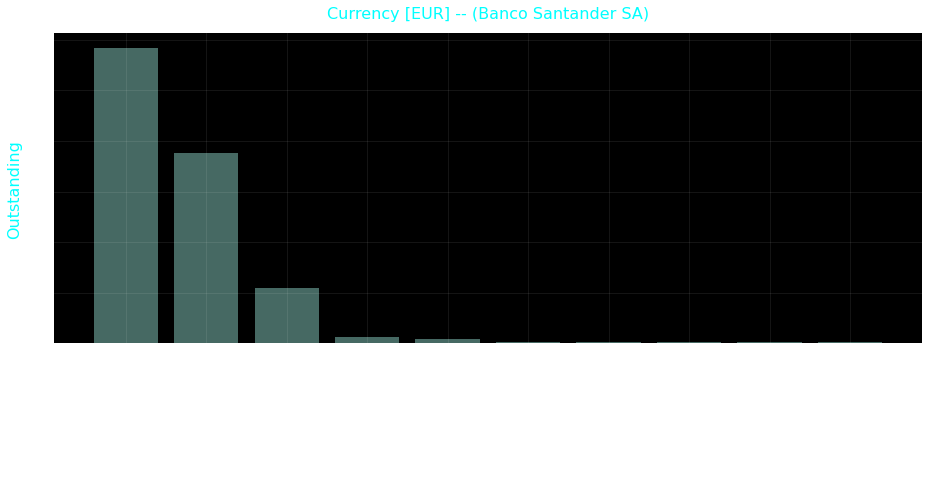

In [47]:
# Plot the data
plt.rcParams['figure.figsize'] = (13,7)

fig, ax = plt.subplots()
ax.tick_params(labelrotation=90)

ax.bar(
    x=np.arange(plt_table.shape[0]),
    height=plt_table['Outstanding', 'sum'],
    tick_label=plt_table.index.get_level_values(1),
    alpha=0.5
)

# Remove the spines from the graph - leave the bottom
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)

ax.tick_params(bottom=False, left=False)

# Add a faint grid
ax.yaxis.grid(True, alpha=0.1)
ax.xaxis.grid(True, alpha=0.1)

# Add labels and a title. Note the use of `labelpad` and `pad` to add some
# extra space between the text and the tick labels.
ax.set_ylabel('Outstanding', labelpad=15, fontsize=16, color='cyan')
ax.set_title(f"Currency [{to_currency}] -- ({company['DTSubjectName'][0]})", pad=15, fontsize=16, color='cyan')

fig.tight_layout()

# Conclusions
In this simple yet constructive article, we have looked at how to use the APIs to search for active bonds for a company, bring back specific properties for the same, and then convert them all into a single currency so we are able to look at the whole picture. The currency conversion done in this article is transferrable to any asset class and any data set. Furthermore, the visualization in a table and chart is useful to get the 'quick big picture' in a large range of use cases. Look out for an article from the same authors on cash flow analysis for a portfolio of bonds where we'll be looking at expected cash flows, pay dates, and much more - all with the use of the basic tips you've learned here. 